In [1]:
! pip install -q geopandas pycountry

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import graph_tool.all as gt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import os
import geopandas as gpd
from matplotlib.colors import rgb2hex
import matplotlib.colors as mcolors
import requests
import zipfile
import io
from pathlib import Path
import pycountry

## Preprocess data

In [3]:
def process_trade_data_normalized(file_path, weight_threshold):
    """
    Processes trade data to create a normalized weighted adjacency matrix based on trade intensity,
    excluding specified regions.

    Parameters:
    - file_path (str): Path to the input CSV file containing trade data.
    - weight_threshold (float): Minimum weight to consider; weights below this are set to zero.

    Returns:
    - pd.DataFrame: A DataFrame representing the normalized weighted adjacency matrix.
    """
    # Define regions to exclude
    regions = [
        "World",
        "Europe & Central Asia",
        "East Asia & Pacific",
        "North America",
        "Middle East & North Africa",
        "Sub-Saharan Africa",
        "South Asia",
        " World",
        "Latin America & Caribbean"
    ]
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Remove rows where either 'Country' or 'Reference Country' is in the regions list
    df = df[
        (~df['Country'].isin(regions)) & 
        (~df['Reference Country'].isin(regions))
    ]
    
    # Get unique countries (combining Reference Country and Country columns)
    all_countries = sorted(set(df['Reference Country']).union(set(df['Country'])))
    
    # Initialize dictionaries to store exports
    exports = {country: 0.0 for country in all_countries}
    bilateral_exports = {}
    
    # Clean and aggregate export values
    for _, row in df.iterrows():
        ref_country = row["Reference Country"]
        country = row["Country"]
        
        # Clean and convert the export value
        export_str = str(row["Export (US$ Thousand)"]).replace(',', '').replace('*', '').strip()
        try:
            export = float(export_str) if export_str else 0.0
        except ValueError:
            # Handle cases where conversion fails
            export = 0.0
        
        exports[ref_country] += export
        bilateral_exports[(ref_country, country)] = bilateral_exports.get((ref_country, country), 0.0) + export
    
    # Initialize an empty matrix filled with zeros
    n = len(all_countries)
    matrix = np.zeros((n, n))
    
    # Create a dictionary for quick country to index lookup
    country_to_index = {country: i for i, country in enumerate(all_countries)}
    
    # Iterate over all unique country pairs to calculate normalized weights
    for i, country_a in enumerate(all_countries):
        for j, country_b in enumerate(all_countries):
            if country_a == country_b:
                continue  # No self-loops; weight remains zero
            
            # Get exports from A to B and B to A
            export_a_to_b = bilateral_exports.get((country_a, country_b), 0.0)
            export_b_to_a = bilateral_exports.get((country_b, country_a), 0.0)
            
            # Calculate total bilateral trade
            total_trade = export_a_to_b + export_b_to_a
            
            # Calculate total exports for normalization
            total_exports_a = exports[country_a]
            total_exports_b = exports[country_b]
            
            if total_exports_a > 0 and total_exports_b > 0:
                # Calculate trade intensity
                trade_intensity = total_trade / (total_exports_a + total_exports_b)
            else:
                trade_intensity = 0.0  # Handle division by zero if any country has zero exports
            
            # Apply weight threshold
            if trade_intensity < weight_threshold:
                trade_intensity = 0.0
            
            # Assign the normalized weight
            matrix[i][j] = trade_intensity
    
    # Create the output DataFrame
    matrix_df = pd.DataFrame(matrix, index=all_countries, columns=all_countries)
    
    # Optionally, reset index and column names if needed
    matrix_df.reset_index(inplace=True)
    matrix_df.rename(columns={'index': 'Country'}, inplace=True)
    
    return matrix_df

def save_matrix(matrix_df, output_file):
    """
    Saves the adjacency matrix to a CSV file.

    Parameters:
    - matrix_df (pd.DataFrame): The adjacency matrix DataFrame.
    - output_file (str): Path to the output CSV file.
    """
    matrix_df.to_csv(output_file, index=False)

# Example usage
if __name__ == "__main__":
    input_file = "./trade/trade_data.csv"            # Your input file path
    output_file = "./trade/trade_matrix_normalized.csv"  # Your output file path

    # Process the trade data with normalized weights
    matrix_df = process_trade_data_normalized(input_file, weight_threshold=0)

    # Save the resulting matrix to a CSV file
    save_matrix(matrix_df, output_file)


## Visualize graph

Loaded adjacency matrix with shape (246, 246).
Initial graph has 246 nodes and 8179 edges.
Removed 615 edges below the weight threshold of 1e-06.
Removed 102 isolated nodes.
Graph saved as ./trade/trade_graph.graphml.


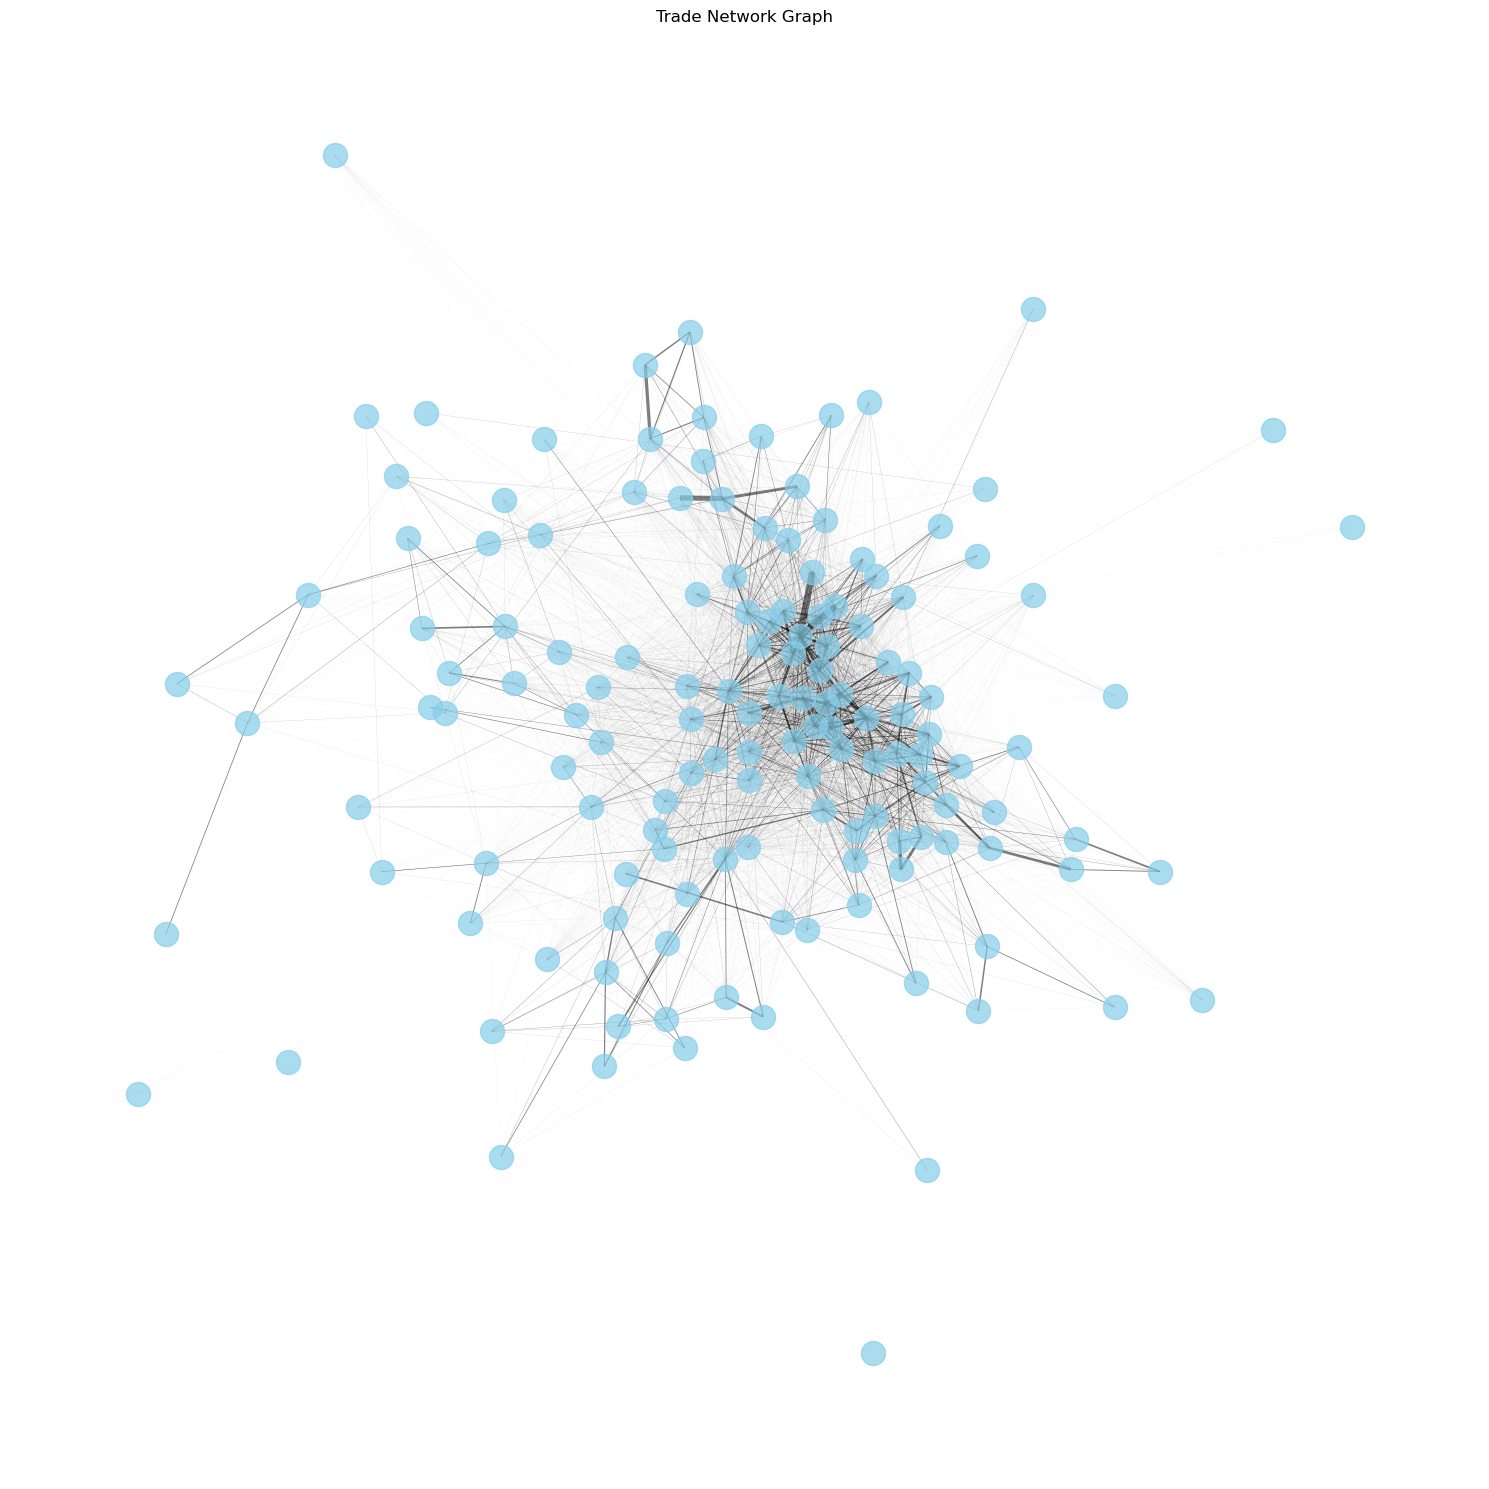

Graph plotted and saved as ./trade/trade_graph.png.


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_graphml_and_plot(csv_file, graphml_file, plot_file, weight_threshold=1e-6):
    """
    Creates a GraphML file from a normalized adjacency matrix and plots the graph.
    
    Parameters:
    - csv_file (str): Path to the input CSV file containing the normalized adjacency matrix.
    - graphml_file (str): Path to save the output GraphML file.
    - plot_file (str): Path to save the plotted graph image.
    - weight_threshold (float): Minimum weight to consider; edges below this are removed.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file, index_col=0)
    print(f"Loaded adjacency matrix with shape {df.shape}.")
    
    # Create graph from adjacency matrix
    G = nx.from_pandas_adjacency(df, create_using=nx.Graph)
    print(f"Initial graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Remove edges below the weight threshold
    if weight_threshold > 0:
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < weight_threshold]
        G.remove_edges_from(edges_to_remove)
        print(f"Removed {len(edges_to_remove)} edges below the weight threshold of {weight_threshold}.")
    
    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed {len(isolated_nodes)} isolated nodes.")
    
    # Save the graph as GraphML
    nx.write_graphml(G, graphml_file)
    print(f"Graph saved as {graphml_file}.")
    
    # Plot the graph
    plt.figure(figsize=(15, 15))
    
    # Choose layout
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
    
    # Extract edge weights for plotting
    edges = G.edges(data=True)
    weights = [d['weight'] for _, _, d in edges]
    
    # Normalize edge widths for better visualization
    max_weight = max(weights) if weights else 1
    normalized_weights = [5 * (w / max_weight) for w in weights]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5)
    
    # Draw labels for a smaller graph
    if G.number_of_nodes() <= 100:
        nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Trade Network Graph")
    plt.axis('off')
    plt.tight_layout()
    
    # Save the plotted graph
    plt.savefig(plot_file, dpi=300)
    plt.show()
    print(f"Graph plotted and saved as {plot_file}.")

# Example usage
if __name__ == "__main__":
    csv_input = "./trade/trade_matrix_normalized.csv"       # Input CSV file path
    graphml_output = "./trade/trade_graph.graphml"         # Output GraphML file path
    plot_output = "./trade/trade_graph.png"                # Output plot image file path
    
    create_graphml_and_plot(csv_input, graphml_output, plot_output)

In [5]:
def create_country_mapping_pycountry():
    """Create mapping using pycountry library"""
    # Initialize mapping dictionary
    mapping = {}
    
    # Get your country list
    your_countries = [
        'Andorra', 'Antigua and Barbuda', 'Aruba', 'Bahrain', 'Barbados',
        'Bermuda', 'Bosnia and Herzegovina', 'Cape Verde', 'Central African Republic',
        'Cote dIvoire', 'Czech Republic', 'Dominican Republic', 'East Timor',
        'Ethiopia(excludes Eritrea)', 'European Union', 'French Polynesia',
        'Grenada', 'Hong Kong', 'Kyrgyz Republic', 'Macao', 'Maldives', 'Malta',
        'Mauritius', 'Montserrat', 'Occ.Pal.Terr', 'Other Asia', 
        'Sao Tome and Principe', 'Seychelles', 'Singapore', 'Slovak Republic',
        'United States'
    ]
    
    # Special cases mapping
    special_cases = {
        'Cote dIvoire': 'Côte d\'Ivoire',
        'East Timor': 'Timor-Leste',
        'Ethiopia(excludes Eritrea)': 'Ethiopia',
        'European Union': None,
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Occ.Pal.Terr': 'Palestine, State of',
        'Other Asia': 'Taiwan',
        'Slovak Republic': 'Slovakia',
        'Czech Republic': 'Czechia',
        'Cape Verde': 'Cabo Verde'
    }
    
    for country in your_countries:
        if country in special_cases:
            mapping[country] = special_cases[country]
        else:
            try:
                # Try exact match
                c = pycountry.countries.get(name=country)
                if c:
                    mapping[country] = c.name
                    continue
                
                # Try fuzzy search
                matches = pycountry.countries.search_fuzzy(country)
                if matches:
                    mapping[country] = matches[0].name
            except LookupError:
                # Keep original name if no match found
                mapping[country] = country
    
    return mapping

def verify_pycountry_mapping(mapping):
    """Verify country mapping using pycountry"""
    print("Mapping Verification (pycountry):")
    print("-" * 30)
    
    for original, mapped in mapping.items():
        if mapped is None:
            print(f"Skipped: {original}")
        elif pycountry.countries.get(name=mapped):
            print(f"✓ {original} -> {mapped}")
        else:
            # Try to find similar names
            try:
                matches = pycountry.countries.search_fuzzy(mapped)
                suggestions = [m.name for m in matches[:3]]
                print(f"✗ {original} -> {mapped} (Suggestions: {', '.join(suggestions)})")
            except LookupError:
                print(f"✗ {original} -> {mapped} (No matches found)")

# Test the new mapping
mapping = create_country_mapping_pycountry()
verify_pycountry_mapping(mapping)

Mapping Verification (pycountry):
------------------------------
✓ Andorra -> Andorra
✓ Antigua and Barbuda -> Antigua and Barbuda
✓ Aruba -> Aruba
✓ Bahrain -> Bahrain
✓ Barbados -> Barbados
✓ Bermuda -> Bermuda
✓ Bosnia and Herzegovina -> Bosnia and Herzegovina
✓ Cape Verde -> Cabo Verde
✓ Central African Republic -> Central African Republic
✓ Cote dIvoire -> Côte d'Ivoire
✓ Czech Republic -> Czechia
✓ Dominican Republic -> Dominican Republic
✓ East Timor -> Timor-Leste
✓ Ethiopia(excludes Eritrea) -> Ethiopia
Skipped: European Union
✓ French Polynesia -> French Polynesia
✓ Grenada -> Grenada
✓ Hong Kong -> Hong Kong
✓ Kyrgyz Republic -> Kyrgyzstan
✓ Macao -> Macao
✓ Maldives -> Maldives
✓ Malta -> Malta
✓ Mauritius -> Mauritius
✓ Montserrat -> Montserrat
✓ Occ.Pal.Terr -> Palestine, State of
✗ Other Asia -> Taiwan (Suggestions: Taiwan, Province of China, China)
✓ Sao Tome and Principe -> Sao Tome and Principe
✓ Seychelles -> Seychelles
✓ Singapore -> Singapore
✓ Slovak Republic -> S

In [6]:
def get_natural_earth_data():
    """Download and cache Natural Earth data"""
    import os
    from pathlib import Path
    import requests
    import zipfile
    
    # Setup paths
    data_dir = Path('./data')
    shp_path = data_dir / 'ne_110m_admin_0_countries.shp'
    
    # Return cached data if exists
    if shp_path.exists():
        return str(shp_path)
    
    # Create data directory
    data_dir.mkdir(exist_ok=True)
    
    # Download data
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    zip_path = data_dir / 'ne_110m_admin_0_countries.zip'
    
    try:
        print("Downloading Natural Earth data...")
        response = requests.get(url)
        response.raise_for_status()
        
        # Save zip file
        zip_path.write_bytes(response.content)
        
        # Extract files
        with zipfile.ZipFile(zip_path) as z:
            z.extractall(data_dir)
            
        # Cleanup
        zip_path.unlink()
        return str(shp_path)
        
    except Exception as e:
        raise RuntimeError(f"Failed to download Natural Earth data: {e}")


In [7]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graph_tool.all as gt
import geopandas as gpd
from matplotlib.colors import rgb2hex
import requests
import zipfile
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')
def get_natural_earth_data():
    """Download and cache Natural Earth data"""
    # Define paths
    data_dir = Path('./data')
    shp_path = data_dir / 'ne_110m_admin_0_countries.shp'
    
    # Return cached data if exists
    if shp_path.exists():
        return str(shp_path)
        
    # Create data directory
    data_dir.mkdir(exist_ok=True)
    
    # Download data
    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"
    zip_path = data_dir / 'natural_earth_data.zip'
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # Save and extract zip file
        zip_path.write_bytes(response.content)
        with zipfile.ZipFile(zip_path) as z:
            z.extractall(data_dir)
            
        # Cleanup
        zip_path.unlink()
        return str(shp_path)
        
    except Exception as e:
        raise RuntimeError(f"Failed to download Natural Earth data: {e}")

class WSBMCommunityDetector:
    def __init__(self, graph_file):
        if not os.path.exists(graph_file):
            raise FileNotFoundError(f"The file {graph_file} does not exist.")

        self.graph = nx.read_graphml(graph_file)
        if self.graph.is_directed():
            self.graph = self.graph.to_undirected()
        
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))
        
        for u, v, d in self.graph.edges(data=True):
            if 'weight' in d:
                try:
                    d['weight'] = float(d['weight'])
                except ValueError:
                    d['weight'] = 1.0
            else:
                d['weight'] = 1.0

    def detect_communities_graphtool(self, n_blocks=None, nested=True):
        gt_graph = gt.Graph(directed=False)
        
        node_mapping = {}
        reverse_mapping = {}
        for node in self.graph.nodes():
            v = gt_graph.add_vertex()
            node_mapping[node] = v
            reverse_mapping[int(v)] = node

        edge_weights = gt_graph.new_edge_property("double")
        gt_graph.edge_properties["weight"] = edge_weights

        for u, v, data in self.graph.edges(data=True):
            e = gt_graph.add_edge(node_mapping[u], node_mapping[v])
            edge_weights[e] = data.get('weight', 1.0)

        if np.any([w < 0 for w in edge_weights.a]):
            raise ValueError("Edge weights must be non-negative.")

        if nested and n_blocks is None:
            state = gt.minimize_nested_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_bs()[0]
        elif n_blocks is not None:
            state = gt.BlockState(gt_graph, B=n_blocks, weight=edge_weights)
            for _ in range(1000):
                state.mcmc_sweep(beta=np.inf)
            blocks = state.get_blocks()
        else:
            state = gt.minimize_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_blocks()

        communities = {}
        for v in range(gt_graph.num_vertices()):
            node = reverse_mapping[v]
            communities[node] = int(blocks[v])

        unique_communities = sorted(set(communities.values()))
        community_map = {comm: idx for idx, comm in enumerate(unique_communities)}
        communities = {node: community_map[comm] for node, comm in communities.items()}

        return communities, state

    def analyze_communities(self, communities):
        comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])
        
        stats = {
            'size': comm_df['Community'].value_counts().sort_index(),
            'members': comm_df.groupby('Community').apply(lambda x: list(x.index))
        }
        
        densities = {}
        avg_weights = {}
        for comm in stats['size'].index:
            members = stats['members'][comm]
            subgraph = self.graph.subgraph(members)
            densities[comm] = nx.density(subgraph)
            weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
            avg_weights[comm] = np.mean(weights) if weights else 0.0

        stats['density'] = pd.Series(densities)
        stats['avg_weight'] = pd.Series(avg_weights)
        return stats

    def plot_dendrogram(self, communities, output_file='dendrogram.png', show=True):
        fig = self._create_dendrogram(communities)
        if output_file:
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close()

    def visualize_communities(self, communities, state, output_file='communities.png', show=True):
        fig = self._create_network_viz(communities)
        if output_file:
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close()

    def visualize_communities_on_map(self, communities, output_file='./trade/community_world_map.png', show=False):
        """Visualize communities on world map"""
        # Debug print
        print("Starting map visualization...")
        
        # Get mappings
        country_mapping, _ = create_country_mapping_pycountry()
        print(f"Loaded {len(country_mapping)} country mappings")
        
        # Load world map data
        world = gpd.read_file(get_natural_earth_data())
        print(f"Loaded world map with {len(world)} countries")
        
        # Create color mapping for communities
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: rgb2hex(colors[i]) for i, comm in enumerate(unique_communities)}
        print(f"Created color mapping for {len(unique_communities)} communities")
        
        # Map communities to countries
        country_communities = {}
        unmapped = set()
        for node, comm in communities.items():
            country = node.split('.')[0] if '.' in node else node
            mapped_country = country_mapping.get(country)
            if mapped_country:
                country_communities[mapped_country] = comm
            else:
                unmapped.add(country)
        
        print(f"Mapped {len(country_communities)} countries to communities")
        if unmapped:
            print(f"Found {len(unmapped)} unmapped countries")
        
        # Create plot
        plt.figure(figsize=(20, 10))
        
        # Create colors column
        default_color = '#D3D3D3'
        world['color_column'] = world['NAME'].map(
            lambda x: color_map.get(country_communities.get(x, -1), default_color)
        )
        
        # Plot
        ax = world.plot(color=world['color_column'], figsize=(20, 10))
        
        # Add legend
        patches = [plt.Rectangle((0,0),1,1, fc=color_map[comm]) for comm in unique_communities]
        plt.legend(patches, 
                [f'Community {comm} ({list(communities.values()).count(comm)} members)' 
                for comm in unique_communities],
                loc='center left', 
                bbox_to_anchor=(1, 0.5))
        
        plt.title('Trade Communities World Map')
        plt.axis('off')
        
        # Save plot
        if output_file:
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Saved map to {output_file}")
        
        # Display plot
        if show:
            plt.show()
        else:
            plt.close()

    def _create_dendrogram(self, communities):
        """Create dendrogram visualization of community structure"""
        # Create mapping of communities to members
        comm_to_members = {}
        for node, comm in communities.items():
            comm_to_members.setdefault(comm, set()).add(node)
        
        unique_communities = sorted(set(communities.values()))
        n_comms = len(unique_communities)
        
        # Skip if only one community
        if n_comms <= 1:
            plt.figure(figsize=(12, 8))
            plt.text(0.5, 0.5, 'Only one community detected', 
                    horizontalalignment='center',
                    verticalalignment='center')
            plt.axis('off')
            return plt.gcf()
        
        # Calculate similarity matrix
        similarity_matrix = np.zeros((n_comms, n_comms))
        for i, comm1 in enumerate(unique_communities):
            members1 = comm_to_members[comm1]
            for j, comm2 in enumerate(unique_communities):
                if i != j:
                    members2 = comm_to_members[comm2]
                    # Calculate Jaccard similarity
                    intersection = len(members1.intersection(members2))
                    union = len(members1.union(members2))
                    similarity_matrix[i, j] = intersection / union if union > 0 else 0
                else:
                    similarity_matrix[i, j] = 1.0  # Self-similarity
        
        # Convert similarity to distance
        distance_matrix = 1 - similarity_matrix
        
        # Verify matrix is valid
        if np.all(distance_matrix == 0):
            plt.figure(figsize=(12, 8))
            plt.text(0.5, 0.5, 'No meaningful distances between communities', 
                    horizontalalignment='center',
                    verticalalignment='center')
            plt.axis('off')
            return plt.gcf()
        
        # Create condensed distance matrix
        condensed_dist = squareform(distance_matrix)
        
        # Perform hierarchical clustering
        Z = linkage(condensed_dist, method='ward')
        
        # Plot dendrogram
        plt.figure(figsize=(12, 8))
        dendrogram(
            Z,
            labels=[f'Community {c}\n({len(comm_to_members[c])} members)' 
                    for c in unique_communities],
            leaf_rotation=90,
            leaf_font_size=10
        )
        plt.title("Community Hierarchy Dendrogram")
        plt.tight_layout()
        return plt.gcf()

    def _create_network_viz(self, communities):
        plt.figure(figsize=(15, 15))
        
        pos = nx.spring_layout(self.graph, k=2, iterations=100, seed=42)
        
        edge_weights = [d['weight'] for (_, _, d) in self.graph.edges(data=True)]
        max_weight = max(edge_weights)
        edge_widths = [2 * (w / max_weight) for w in edge_weights]
        
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        
        nx.draw_networkx_edges(self.graph, pos, 
                              width=edge_widths,
                              alpha=0.3,
                              edge_color='gray')
        
        for comm_idx, comm in enumerate(unique_communities):
            node_list = [node for node, c in communities.items() if c == comm]
            nx.draw_networkx_nodes(self.graph, pos,
                                 nodelist=node_list,
                                 node_color=[colors[comm_idx]],
                                 node_size=300,
                                 label=f'Community {comm} ({len(node_list)})')
        
        labels = {node: node.split('.')[0] for node in self.graph.nodes()}
        nx.draw_networkx_labels(self.graph, pos, labels,
                              font_size=8,
                              font_weight='bold')
        
        plt.title("Trade Communities Network", pad=20)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt.gcf()

    def _create_map_viz(self, communities):
        world = gpd.read_file(self._download_natural_earth_data())
        
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: rgb2hex(colors[i]) for i, comm in enumerate(unique_communities)}
        
        country_communities = {}
        for node, comm in communities.items():
            country = node.split('.')[0] if '.' in node else node
            country_communities[country] = comm
        
        fig, ax = plt.subplots(figsize=(20, 10))
        
        world['colors'] = world['NAME'].map(lambda x: color_map.get(country_communities.get(x, -1), '#f0f0f0'))
        world.plot(color=world['colors'], ax=ax)
        
        patches = [plt.Rectangle((0,0), 1, 1, fc=color_map[comm]) 
                  for comm in unique_communities]
        plt.legend(patches,
                  [f'Community {comm} ({list(communities.values()).count(comm)})' 
                   for comm in unique_communities],
                  loc='center left',
                  bbox_to_anchor=(1, 0.5))
        
        plt.title('Trade Communities World Map')
        plt.axis('off')
        return plt.gcf()
    
    def visualize_all(self, communities, state, output_dir='./trade/visualizations', display=True):
        """Visualize communities with inline display"""
        os.makedirs(output_dir, exist_ok=True)
        
        print("Generating network visualization...")
        self.visualize_communities(communities, state, show=display)
        
        print("\nGenerating dendrogram...")
        self.plot_dendrogram(communities, show=display)
        
        print("\nGenerating world map...")
        self.visualize_communities_on_map(communities, show=display)



Generating network visualization...


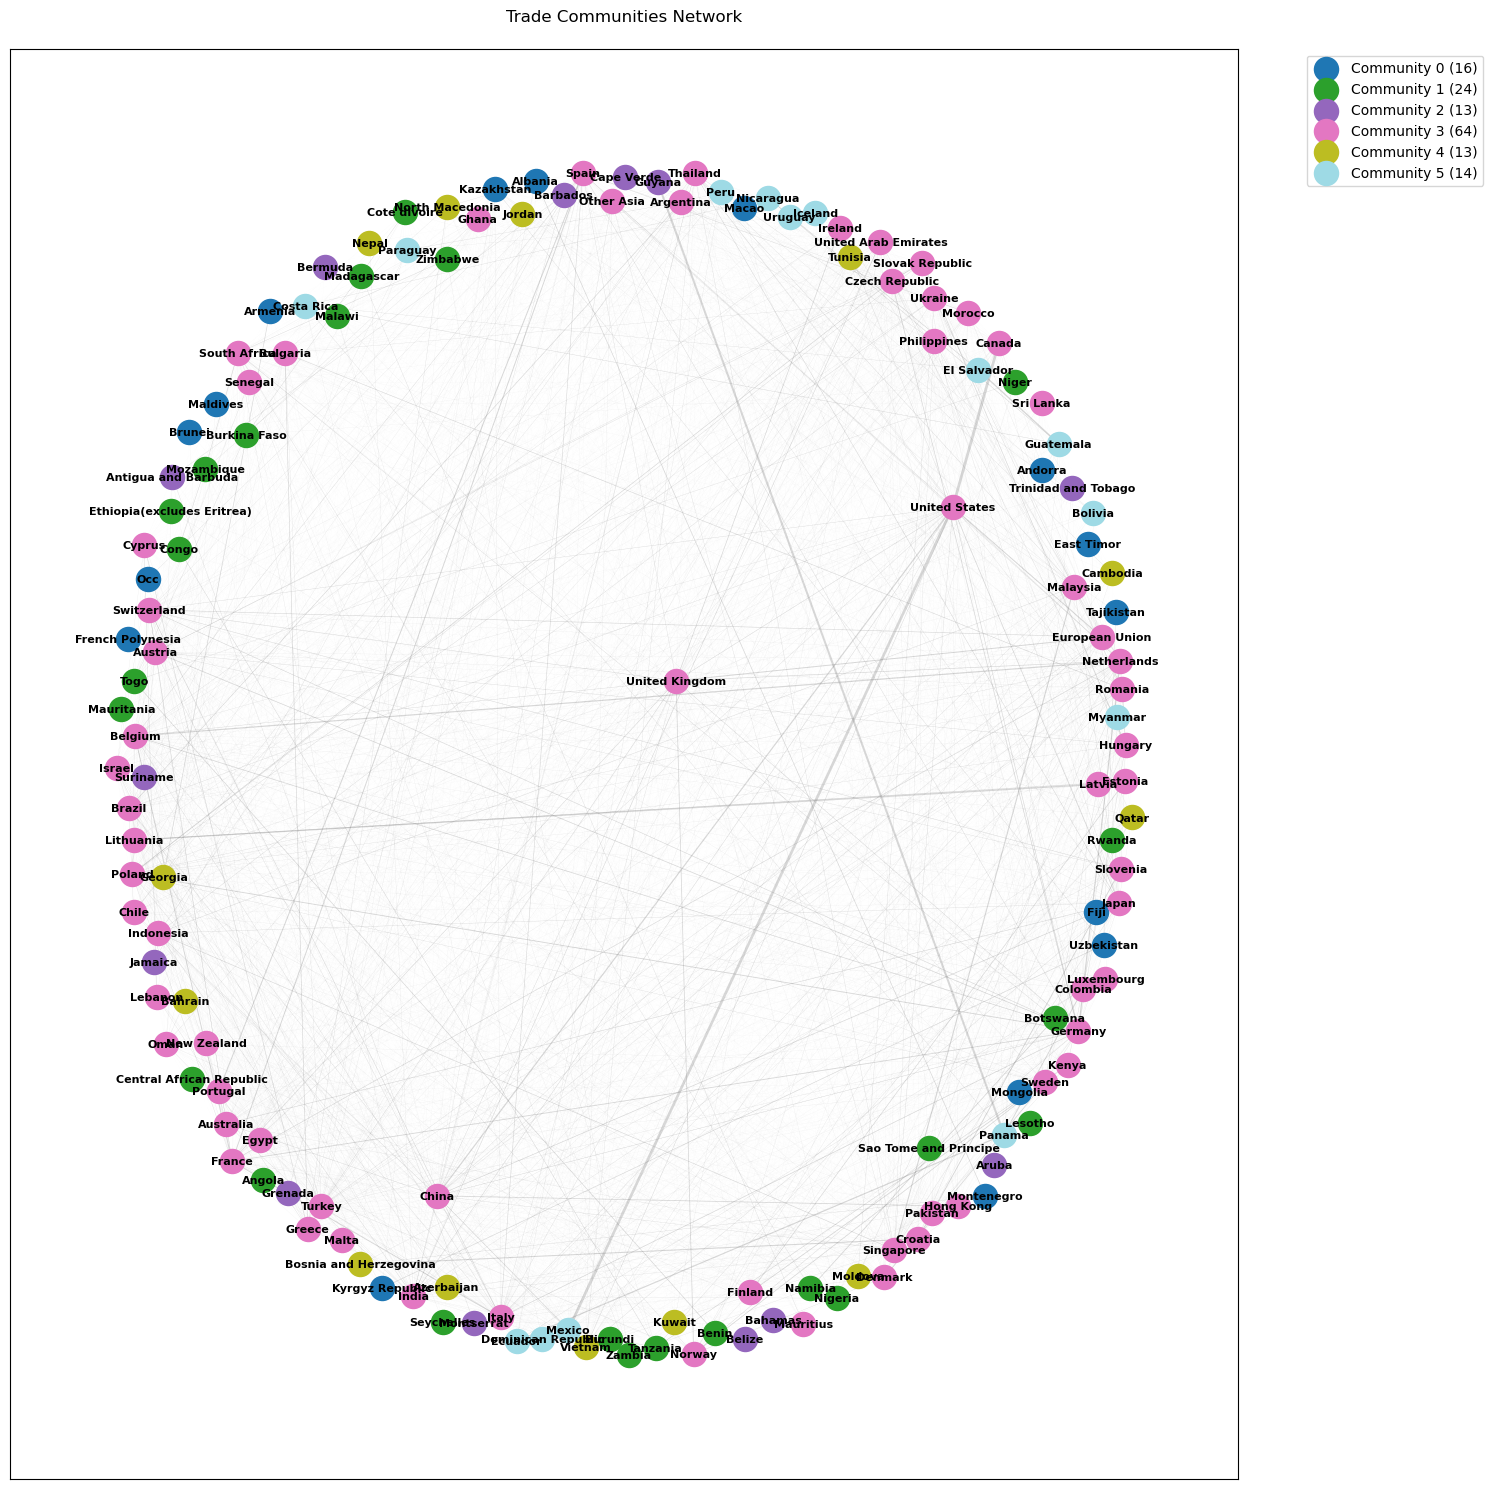


Generating dendrogram...


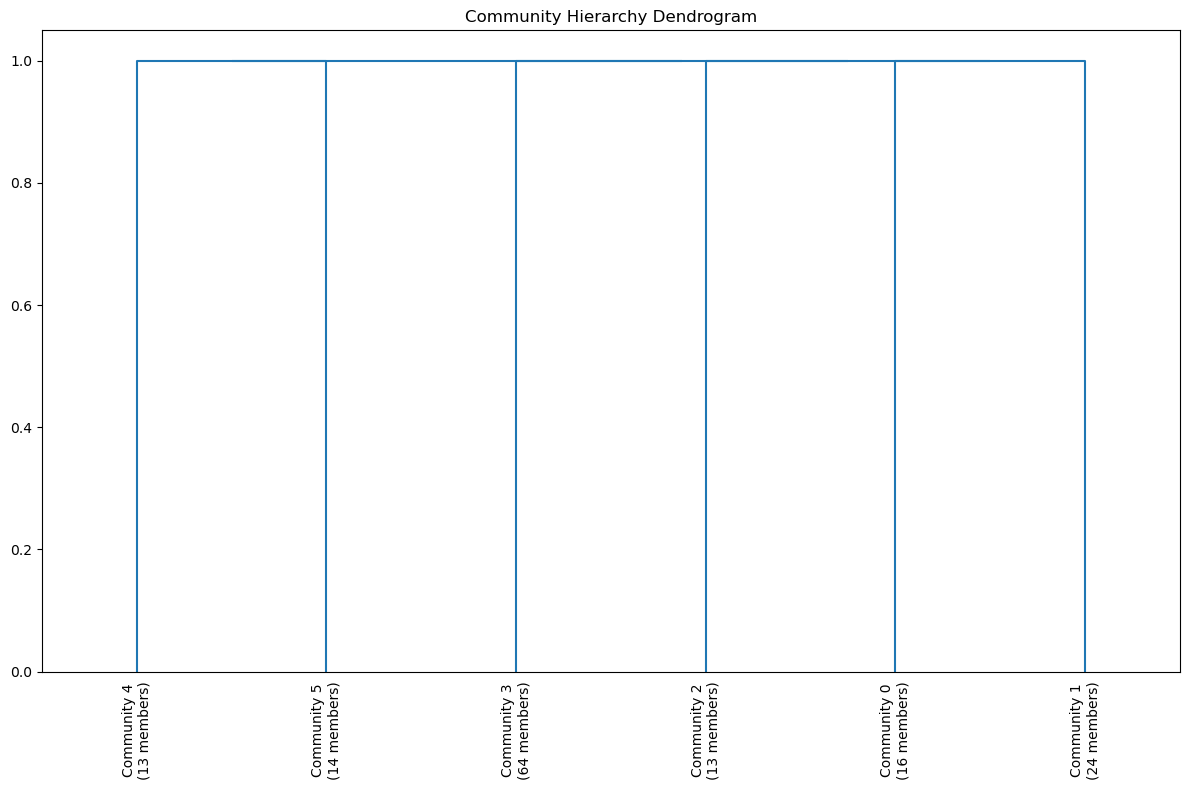


Generating world map...
Starting map visualization...
Loaded 440 country mappings
Loaded world map with 177 countries
Created color mapping for 6 communities
Mapped 138 countries to communities
Found 6 unmapped countries
Saved map to ./trade/community_world_map.png


<Figure size 2000x1000 with 0 Axes>

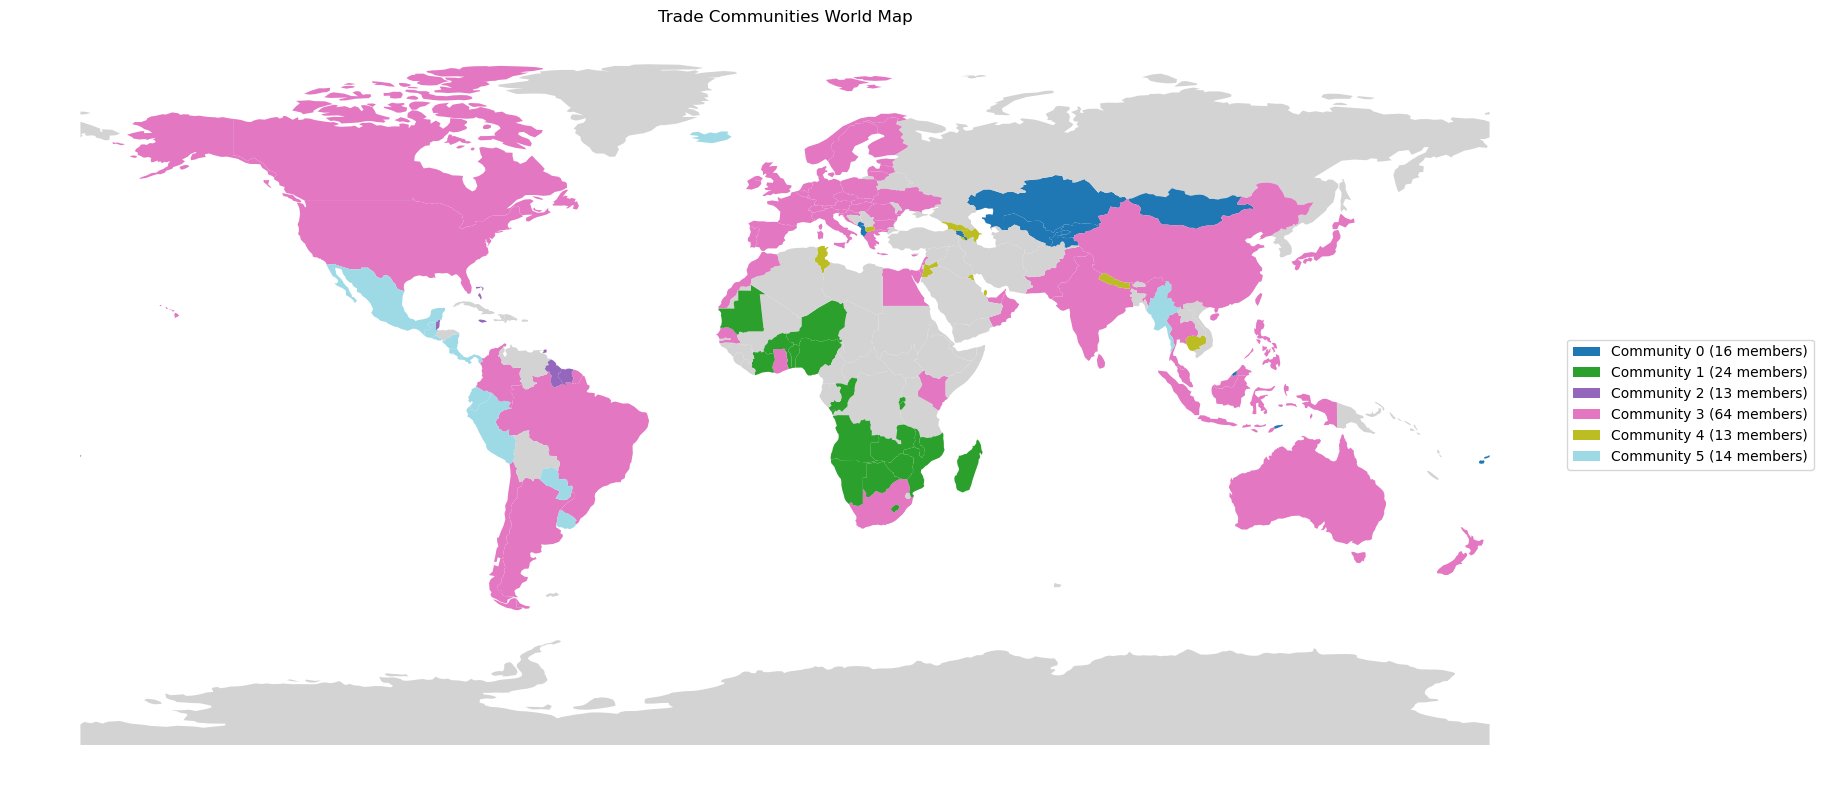

In [8]:
def create_country_mapping_pycountry():
    """Create comprehensive country mapping using pycountry"""
    
    country_mapping = {}
    
    # Manual mappings for special cases with Natural Earth names
    special_cases = {
        'USA': 'United States of America',
        'United States': 'United States of America',
        'UK': 'United Kingdom',
        'United Kingdom': 'United Kingdom',
        'UAE': 'United Arab Emirates',
        'Cote dIvoire': "Côte d'Ivoire",
        'East Timor': 'Timor-Leste',
        'European Union': None,
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Occ.Pal.Terr': 'Palestine',
        'Other Asia': 'Taiwan',
        'Czech Republic': 'Czechia',
        'Cape Verde': 'Cabo Verde',
        'Brunei': 'Brunei',
        'Congo': 'Congo',
        'Hong Kong': None,  # Ignore territories
        'Macao': None,  # Ignore territories
        'Korea, Rep.': 'South Korea',
        'Iran, Islamic Rep.': 'Iran',
        'Egypt, Arab Rep.': 'Egypt',
        'Syrian Arab Republic': 'Syria',
        'Venezuela, RB': 'Venezuela',
        'Yemen, Rep.': 'Yemen',
        'Gambia, The': 'Gambia',
        'Bahamas, The': 'Bahamas',
        'China': 'China',  # Ensure direct mapping
    }
    
    # Add all pycountry countries with Natural Earth names
    for country in pycountry.countries:
        # Standard name mapping to Natural Earth names
        natural_earth_name = special_cases.get(country.name, country.name)
        if natural_earth_name:
            country_mapping[country.name] = natural_earth_name
            if hasattr(country, 'common_name'):
                country_mapping[country.common_name] = natural_earth_name
            if hasattr(country, 'official_name'):
                country_mapping[country.official_name] = natural_earth_name
    
    # Add special cases
    country_mapping.update(special_cases)
    
    # Return only country mapping, no territories
    return country_mapping, {}
# Usage
# Initialize and run
detector = WSBMCommunityDetector("./trade/trade_graph.graphml")
communities, state = detector.detect_communities_graphtool(n_blocks=10)
%matplotlib inline
detector.visualize_all(communities, state)